# Modelo No Supervisado – Clustering de Sensores con K‑Means

Objetivo: agrupar sensores por su patrón de llenado a partir de la serie temporal Valor, generando perfiles operativos (llenado rápido/estable/descenso) para optimizar rutas y mantenimiento.

🔑 Entradas esperadas

* CSV con columnas:

    * Fecha (datetime), 
    * Valor (numérico), 
    * Sensor_Id (id del sensor)
    * (opcionales) Hora, DiaSemana

📤 Salidas principales

* Tabla de sensores con: cluster, PCA1, PCA2, features por sensor

* 3 visualizaciones:

    * Mapa PCA por clúster

    * Barras de promedios por clúster (valor_mean y rate_valor)

    * Boxplot de Valor por clúster

* Métricas: silhouette (y Calinski‑Harabasz)

# 1) Imports y Configuración

In [1]:
# 1) IMPORTS Y CONFIG
import os
os.environ["OMP_NUM_THREADS"] = "1"  # evita warning/bug MKL en Windows

import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"


# Rutas
CSV_PATH = r"C:/Users/PC-23/Downloads/lecturas_todos_sensores.csv"  # <-- ajusta si cambia
OUT_FIGS_DIR = "figuras"
OUT_MODELS_DIR = "modelos"
OUT_TABLES_DIR = "salidas"

os.makedirs(OUT_FIGS_DIR, exist_ok=True)
os.makedirs(OUT_MODELS_DIR, exist_ok=True)
os.makedirs(OUT_TABLES_DIR, exist_ok=True)

ts = datetime.now().strftime("%Y%m%d_%H%M%S")


# 2) Carga y Limpieza de Datos

In [3]:
# 2) CARGA Y LIMPIEZA
df = pd.read_csv(CSV_PATH)

# Tipos correctos
df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
df["Valor"] = pd.to_numeric(df["Valor"], errors="coerce")

# Filtrado básico y orden
df = df.dropna(subset=["Sensor_Id", "Valor", "Fecha"]).copy()
df = df.sort_values(["Sensor_Id", "Fecha"])

print("Registros:", len(df))
display(df.head())


Registros: 10010


,Fecha,Valor,Sensor_Id,Hora,DiaSemana
0,2025-08-17 04:30:00,18.93,11,4,Sunday
1,2025-08-17 04:35:00,76.33,11,4,Sunday
2,2025-08-17 04:40:00,60.20,11,4,Sunday
3,2025-08-17 04:45:00,56.31,11,4,Sunday
4,2025-08-17 04:50:00,64.60,11,4,Sunday


# 3) Ingeniería de Características (por sensor)

In [4]:
# 3) FEATURES POR SENSOR
g = df.groupby("Sensor_Id", as_index=False)

# Estadísticos básicos
feat = g.agg(
    valor_mean=("Valor", "mean"),
    valor_std=("Valor", "std"),
    valor_min=("Valor", "min"),
    valor_max=("Valor", "max"),
)

# Dinámica: tasa de cambio/hora (mediana por sensor)
df["delta_valor"] = df.groupby("Sensor_Id")["Valor"].diff()
df["delta_t"] = df.groupby("Sensor_Id")["Fecha"].diff().dt.total_seconds()
df["rate_valor"] = (df["delta_valor"] / df["delta_t"]) * 3600

rate = (df.groupby("Sensor_Id", as_index=False)["rate_valor"]
          .median()
          .rename(columns={"rate_valor": "rate_valor"}))

feat = feat.merge(rate, on="Sensor_Id", how="left")
feat["rate_valor"] = feat["rate_valor"].fillna(0)

display(feat.head())


,Sensor_Id,valor_mean,valor_std,valor_min,valor_max,rate_valor
0,11,55.408022,17.719768,10.58,98.78,-4.92
1,12,55.084915,18.347181,12.18,97.93,7.62
2,13,54.664555,18.889985,11.44,99.23,5.52
3,14,55.563986,18.107991,12.28,98.37,-4.32
4,15,54.552587,18.799310,10.89,99.26,-3.78


# 4) Escalamiento y Selección de K

In [5]:
# 4) SCALE + SELECT K 
import os
os.environ["OMP_NUM_THREADS"] = "1"

num_cols = ["valor_mean", "valor_std", "valor_min", "valor_max", "rate_valor"]
X = feat[num_cols].copy()
X = X.fillna(X.median(numeric_only=True))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_k, best_sil, best_model = None, -1, None
for k in range(2, 7):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)  # n_init fijo por compatibilidad
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    if sil > best_sil:
        best_k, best_sil, best_model = k, sil, km

feat["cluster"] = best_model.predict(X_scaled)

# Métricas
silhouette = best_sil
calinski = calinski_harabasz_score(X_scaled, feat["cluster"]) if len(np.unique(feat["cluster"])) > 1 else -1

print(f"Mejor K = {best_k} | silhouette = {silhouette:.3f} | Calinski-Harabasz = {calinski:.1f}")


Mejor K = 5 | silhouette = 0.343 | Calinski-Harabasz = 9.0


# 5) PCA para Visualización

In [13]:
# 5) PCA 2D
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaled)
feat["PCA1"], feat["PCA2"] = Z[:, 0], Z[:, 1]

print("Varianza explicada PCA:", np.round(pca.explained_variance_ratio_, 4))


Varianza explicada PCA: [0.5342 0.2782]


# 6) Visualizaciones (3 gráficas)

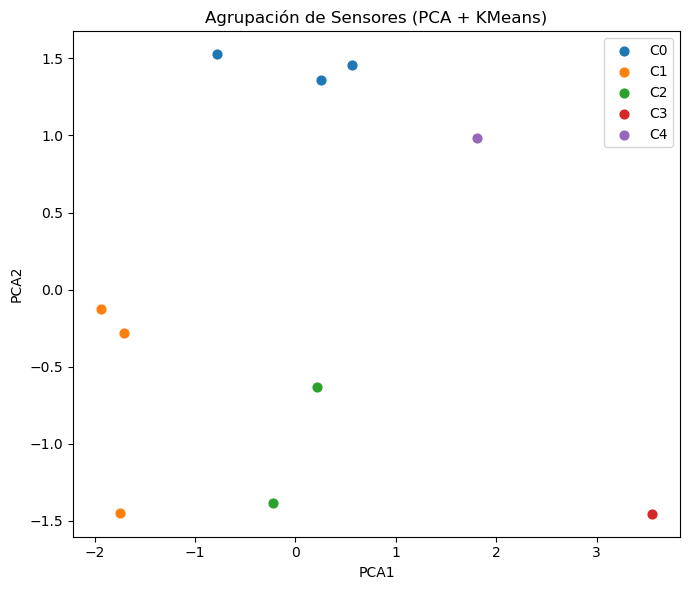

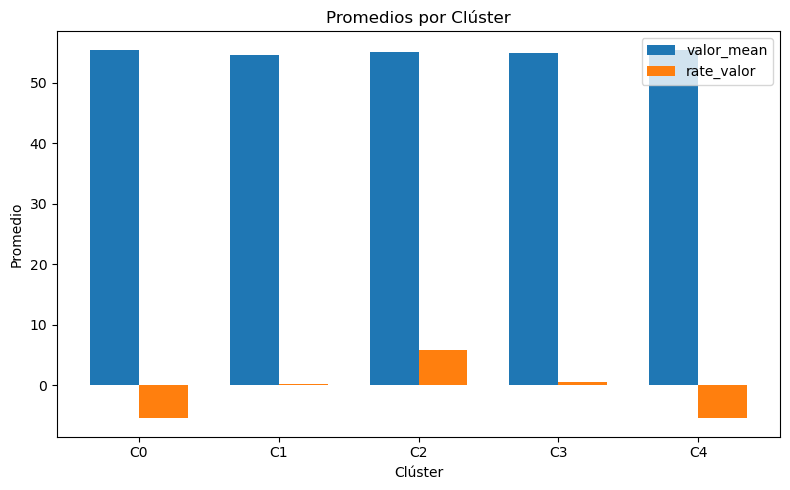

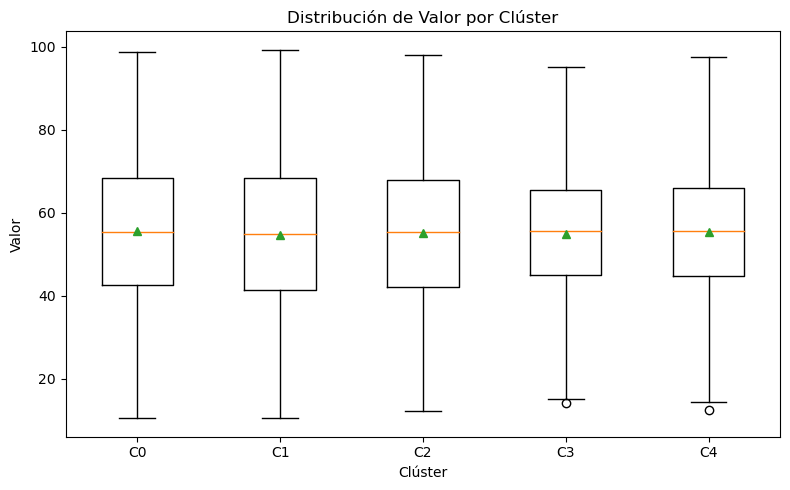

Figuras guardadas:
 - figuras/pca_clusters_20250820_164524.png
 - figuras/barras_perfil_20250820_164524.png
 - figuras/boxplot_valor_20250820_164524.png


In [14]:
# 6) GRÁFICAS
# 6.1) PCA por clúster
plt.figure(figsize=(7,6))
for c in sorted(feat["cluster"].unique()):
    sub = feat[feat["cluster"] == c]
    plt.scatter(sub["PCA1"], sub["PCA2"], s=40, label=f"C{c}")
plt.legend()
plt.title("Agrupación de Sensores (PCA + KMeans)")
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.tight_layout()
path_pca = f"{OUT_FIGS_DIR}/pca_clusters_{ts}.png"
plt.savefig(path_pca, dpi=150)
plt.show()

# 6.2) Barras de promedios por clúster
perfil = (feat.groupby("cluster")[["valor_mean","rate_valor"]]
          .mean()
          .round(2))
plt.figure(figsize=(8,5))
idx = np.arange(len(perfil))
bw = 0.35
plt.bar(idx - bw/2, perfil["valor_mean"].values, width=bw, label="valor_mean")
plt.bar(idx + bw/2, perfil["rate_valor"].values, width=bw, label="rate_valor")
plt.xticks(idx, [f"C{c}" for c in perfil.index])
plt.title("Promedios por Clúster")
plt.xlabel("Clúster"); plt.ylabel("Promedio")
plt.legend()
plt.tight_layout()
path_barras = f"{OUT_FIGS_DIR}/barras_perfil_{ts}.png"
plt.savefig(path_barras, dpi=150)
plt.show()

# 6.3) Boxplot de Valor por clúster (usando lecturas originales)
df_clusters = df.merge(feat[["Sensor_Id","cluster"]], on="Sensor_Id", how="left")
data_box = [df_clusters.loc[df_clusters["cluster"]==c, "Valor"].dropna().values
            for c in sorted(feat["cluster"].unique())]
plt.figure(figsize=(8,5))
plt.boxplot(data_box, labels=[f"C{c}" for c in sorted(feat["cluster"].unique())], showmeans=True)
plt.title("Distribución de Valor por Clúster")
plt.xlabel("Clúster"); plt.ylabel("Valor")
plt.tight_layout()
path_box = f"{OUT_FIGS_DIR}/boxplot_valor_{ts}.png"
plt.savefig(path_box, dpi=150)
plt.show()

print("Figuras guardadas:")
print(" -", path_pca)
print(" -", path_barras)
print(" -", path_box)


# 7) Perfiles y Reglas Operativas

In [15]:
# 7) PERFILES Y REGLAS
perfil_completo = (feat.groupby("cluster")[["valor_mean","valor_std","valor_min","valor_max","rate_valor"]]
                   .mean()
                   .round(2))
display(perfil_completo)

# Etiquetas operativas simples basadas en rate_valor (ajusta umbrales)
def etiquetar(rate):
    if rate >= 2:      return "Llenado rápido"
    if 0.5 <= rate < 2:return "Llenado medio"
    if -0.5 < rate < 0.5:return "Estable"
    if -2 < rate <= -0.5:return "Descenso lento"
    return "Descenso rápido"

feat["cluster_label"] = feat["rate_valor"].apply(etiquetar)

# Recomendación de acción
def recomendar(rate):
    if rate >= 2:          return "Prioridad alta de recolección"
    if 0.5 <= rate < 2:    return "Programar recolección"
    if -0.5 < rate < 0.5:  return "Monitoreo normal"
    if -2 < rate <= -0.5:  return "Reciente vaciado / normal"
    return "Revisar: descenso fuerte"

feat["recomendacion"] = feat["rate_valor"].apply(recomendar)

display(feat[["Sensor_Id","cluster","cluster_label","rate_valor","valor_mean","recomendacion"]].head())


,valor_mean,valor_std,valor_min,valor_max,rate_valor
cluster,,,,,
0,55.48,18.05,11.84,98.36,-5.42
1,54.64,18.68,10.92,99.10,0.26
2,55.14,17.95,12.23,98.00,5.85
3,54.90,14.97,14.08,95.04,0.54
4,55.36,15.12,12.36,97.50,-5.34


,Sensor_Id,cluster,cluster_label,rate_valor,valor_mean,recomendacion
0,11,0,Descenso rápido,-4.92,55.408022,Revisar: descenso fuerte
1,12,2,Llenado rápido,7.62,55.084915,Prioridad alta de recolección
2,13,1,Llenado rápido,5.52,54.664555,Prioridad alta de recolección
3,14,0,Descenso rápido,-4.32,55.563986,Revisar: descenso fuerte
4,15,1,Descenso rápido,-3.78,54.552587,Revisar: descenso fuerte


# 8) Guardado de Resultados y Artefactos

In [16]:
# 8) EXPORTS
path_feat = f"{OUT_TABLES_DIR}/sensores_cluster_{ts}.csv"
feat.to_csv(path_feat, index=False)

# (Opcional) Guardar modelo y scaler para scoring futuro
import joblib
path_model = f"{OUT_MODELS_DIR}/kmeans_{ts}.pkl"
path_scaler = f"{OUT_MODELS_DIR}/scaler_{ts}.pkl"
joblib.dump(best_model, path_model)
joblib.dump(scaler, path_scaler)

# Resumen JSON de métricas y parámetros
summary = {
    "timestamp": ts,
    "mejor_k": int(best_k),
    "silhouette": float(silhouette),
    "calinski_harabasz": float(calinski),
    "figuras": {
        "pca": path_pca,
        "barras": path_barras,
        "boxplot": path_box
    },
    "tablas": {
        "sensores_cluster": path_feat
    },
    "modelos": {
        "kmeans": path_model,
        "scaler": path_scaler
    }
}
with open(f"{OUT_MODELS_DIR}/resumen_{ts}.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print("Resultados guardados:")
print(" - Tabla:", path_feat)
print(" - Modelo:", path_model)
print(" - Scaler:", path_scaler)
print(" - Resumen JSON:", f"{OUT_MODELS_DIR}/resumen_{ts}.json")


Resultados guardados:
 - Tabla: salidas/sensores_cluster_20250820_164524.csv
 - Modelo: modelos/kmeans_20250820_164524.pkl
 - Scaler: modelos/scaler_20250820_164524.pkl
 - Resumen JSON: modelos/resumen_20250820_164524.json
